In [1]:
import numpy as np
from Utilities.file_crop_beat import file_crop_beat
import time
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from libfmp.b.b_plot import plot_signal, plot_chromagram
from libfmp.c3.c3s2_dtw_plot import plot_matrix_with_points
from synctoolbox.feature.utils import estimate_tuning
from synctoolbox.feature.pitch_onset import audio_to_pitch_onset_features
from synctoolbox.feature.dlnco import pitch_onset_features_to_DLNCO
from synctoolbox.feature.pitch import audio_to_pitch_features
from synctoolbox.feature.chroma import pitch_to_chroma, quantize_chroma
from synctoolbox.feature.chroma import quantized_chroma_to_CENS
from synctoolbox.dtw.utils import compute_optimal_chroma_shift
from synctoolbox.dtw.utils import shift_chroma_vectors
from synctoolbox.dtw.mrmsdtw import sync_via_mrmsdtw
from synctoolbox.dtw.utils import make_path_strictly_monotonic

import pandas as pd
import scipy
from synctoolbox.dtw.utils import evaluate_synchronized_positions
header_name = ["time","beat"]


from synctoolbox.dtw.core import compute_warping_path
from synctoolbox.dtw.cost import cosine_distance

In [2]:
def get_features_from_audio(audio, tuning_offset, visualize=True):
    f_pitch = audio_to_pitch_features(f_audio=audio, Fs=Fs, tuning_offset=tuning_offset, feature_rate=feature_rate)
    print('shape pitch features',f_pitch.shape)
    f_chroma = pitch_to_chroma(f_pitch=f_pitch)
    f_chroma_quantized = quantize_chroma(f_chroma=f_chroma)

    f_pitch_onset = audio_to_pitch_onset_features(f_audio=audio, Fs=Fs, tuning_offset=tuning_offset)
    print('shape pitch onset features: ', len(f_pitch_onset))
    f_DLNCO = pitch_onset_features_to_DLNCO(f_peaks=f_pitch_onset, feature_rate=feature_rate, feature_sequence_length=f_chroma_quantized.shape[1])
    return f_chroma_quantized, f_DLNCO

In [4]:
#Parameters
#147.1 and 329.1 bars correctly anotated 

Fs = 22050
beat_start = 147.1
beat_stop = 329.1
feature_rate = 25
step_weights = np.array([1.5, 1.5, 2.0]) #DTW step weights (up, left and diagonal)
threshold_rec = 10 ** 6 

#Croping or saving the alignement
crop = False
save = True
compare = True

In [5]:
audio_path_ref ="/home/osboxes/Desktop/Dataset/01_Audio/01_Full_Symphonies/2003_Gielen_Mahler_IX-1" 
audio_path_align = "/home/osboxes/Desktop/Dataset/01_Audio/01_Full_Symphonies/1965_Bernstein_Mahler_IX-1"


file_path_ref = "/home/osboxes/Desktop/Dataset/02_Beat_per_beat_annotation/01_Full_Symphonies/2003_Gielen_Mahler_IX-1_bpb_final"
file_path_align ="/home/osboxes/Desktop/Dataset/02_Beat_per_beat_annotation/01_Full_Symphonies/1965_Bernstein_Mahler_IX-1_bpb_final" 

In [11]:
audio_path_ref + "_s"+str(beat_start)+"_e"+str(beat_stop)+".wav"

'/home/osboxes/Desktop/Dataset/01_Audio/01_Full_Symphonies/2003_Gielen_Mahler_IX-1_s147.1_e329.1.wav'

In [44]:
import os, re
base = os.path.basename(audio_path_ref)+ "_s"+str(beat_start)+"_e"+str(beat_stop)+".wav"
print(base)
pattern = '_s'+r'[0-3]?[0-9]+.[0-9]'+'_e'+r'[0-3]?[0-9]+.[0-9]'
match = re.search(pattern, base)
print(match)
if match:
    cropped_beats = match.group(0)
    print('it match')



2003_Gielen_Mahler_IX-1_s147.1_e329.1.wav
<re.Match object; span=(23, 37), match='_s147.1_e329.1'>
it match


In [54]:
file_name = os.path.basename(audio_path_ref)
for file in os.listdir('/home/osboxes/Desktop/Dataset/02_Beat_per_beat_annotation/02_Cropped_Symphonies/'):
    base_name = os.path.basename(file)
    print(base_name)
    print(file_name)
    pattern = file_name + r'.*' + cropped_beats
    print(pattern)
    match = re.search(pattern, base_name)
    if match:
        print('Match !')
        print(match.group(0))

1965_Bernstein_Mahler_IX-1_bpb_final_s147.1_e329.1.txt
2003_Gielen_Mahler_IX-1
2003_Gielen_Mahler_IX-1.*_s147.1_e329.1
2003_Gielen_Mahler_IX-1_bpb_final_s147.1_e329.1.txt
2003_Gielen_Mahler_IX-1
2003_Gielen_Mahler_IX-1.*_s147.1_e329.1
Match !
2003_Gielen_Mahler_IX-1_bpb_final_s147.1_e329.1


In [56]:
from Utilities.annotation_path_from_audio_path import annotation_from_audio

a = annotation_from_audio('/home/osboxes/Desktop/Dataset/01_Audio/02_Cropped_Symphonies/2003_Gielen_Mahler_IX-1_s147.1_e329.1.wav')

In [70]:
file_name = os.path.basename('/home/osboxes/Desktop/Dataset/01_Audio/02_Cropped_Symphonies/2003_Gielen_Mahler_IX-1_s147.1_e329.1.wav')[:-4]
cropped = False

#We do some regular expression check to see if it is a crop file or a whole symphonie
pattern = '_s'+r'[0-3]?[0-9]+.[0-9]'+'_e'+r'[0-3]?[0-9]+.[0-9]'
search = re.search(pattern,file_name)
if search:
    cropped = True
    cropped_beats = search.group(0)
    print(cropped_beats)

#If it is cropped: 
if cropped:
    folder_path = '/home/osboxes/Desktop/Dataset/02_Beat_per_beat_annotation/02_Cropped_Symphonies/'
    for file in os.listdir(folder_path):
        
        base_name = os.path.basename(file)
        file_name = re.sub(cropped_beats, '',file_name)
        pattern = file_name + r'.*' + cropped_beats
        search = re.search(pattern,base_name)
        if search :
            return search.group(0)+'.txt'

2003_Gielen_Mahler_IX-1_s147.1_e329.1
_s147.1_e329.1
2003_Gielen_Mahler_IX-1
2003_Gielen_Mahler_IX-1
match !
2003_Gielen_Mahler_IX-1_bpb_final_s147.1_e329.1.txt


In [59]:
cropped

True

In [6]:
if crop :
    file_crop_beat(beat_start = beat_start, beat_stop = beat_stop, data_path = file_path_ref+'.txt', audio_path = audio_path_ref+'.mp3')
    file_crop_beat(beat_start = beat_start, beat_stop = beat_stop, data_path = file_path_align+'.txt', audio_path = audio_path_align+'.mp3')

In [7]:
audio_ref, _ = librosa.load(audio_path_ref + "_s"+str(beat_start)+"_e"+str(beat_stop)+".wav", Fs)
audio_align, _ = librosa.load(audio_path_align +"_s"+str(beat_start)+"_e"+str(beat_stop)+".wav", Fs)

tuning_offset_ref = estimate_tuning(audio_ref, Fs)
tuning_offset_align = estimate_tuning(audio_align, Fs)

f_chroma_quantized_ref, f_DLNCO_ref = get_features_from_audio(audio_ref, tuning_offset_ref)
f_chroma_quantized_align, f_DLNCO_align = get_features_from_audio(audio_align, tuning_offset_align)

f_cens_1hz_ref = quantized_chroma_to_CENS(f_chroma_quantized_ref, 201, 50, feature_rate)[0]
f_cens_1hz_align = quantized_chroma_to_CENS(f_chroma_quantized_align, 201, 50, feature_rate)[0]
opt_chroma_shift = compute_optimal_chroma_shift(f_cens_1hz_ref, f_cens_1hz_align)

f_chroma_quantized_align = shift_chroma_vectors(f_chroma_quantized_align, opt_chroma_shift)
f_DLNCO_align = shift_chroma_vectors(f_DLNCO_align, opt_chroma_shift)

wp = sync_via_mrmsdtw(f_chroma1=f_chroma_quantized_ref, f_onset1=f_DLNCO_ref, f_chroma2=f_chroma_quantized_align, f_onset2=f_DLNCO_align, input_feature_rate=feature_rate, step_weights=step_weights, threshold_rec=threshold_rec)

/home/osboxes/miniconda3/envs/sdia-python/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: '/home/osboxes/Desktop/Dataset/01_Audio/01_Full_Symphonies/2003_Gielen_Mahler_IX-1_s147.1_e329.1.wav'

In [9]:
f_chroma_quantized_ref.shape

(12, 4954)

In [10]:
print(audio_align.shape, audio_ref.shape)


(4431024,) (4367848,)


In [11]:
wp2 = make_path_strictly_monotonic(wp)

Text(0.5, 1.0, 'Strictly monotonic WP')

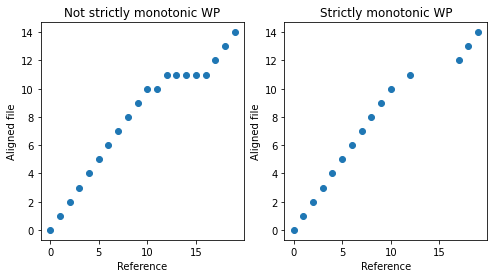

In [20]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(wp[0][0:20],wp[1][0:20],'o')
plt.xlabel('Reference')
plt.ylabel('Aligned file')
plt.title('Not strictly monotonic WP')

plt.subplot(1,2,2)
plt.plot(wp2[0][0:15],wp2[1][0:15],'o')
plt.xlabel('Reference')
plt.ylabel('Aligned file')
plt.title('Strictly monotonic WP')

In [9]:
print(wp2[0][-1]/feature_rate)
print(wp2[1][-1]/feature_rate) 

198.12
200.96


In [10]:
beat_annotations_ref = pd.read_csv(filepath_or_buffer=file_path_ref+"_s"+str(beat_start)+"_e"+str(beat_stop)+".csv",names = header_name)
beat_annotations_align = pd.read_csv(filepath_or_buffer=file_path_align+"_s"+str(beat_start)+"_e"+str(beat_stop)+".csv", names = header_name)
beat_annotations_align = beat_annotations_align.loc[beat_annotations_align['beat'].isin(beat_annotations_ref['beat'])].reset_index(drop = True) #We make sure that we compare only the same beats 


beat_positions_ref_transferred_to_align = scipy.interpolate.interp1d(wp2[0]/ feature_rate , wp2[1]/ feature_rate , kind='linear')(beat_annotations_ref["time"])


mean_absolute_error, accuracy_at_tolerances = evaluate_synchronized_positions(beat_annotations_align["time"] * 1000, beat_positions_ref_transferred_to_align * 1000)

Measure transfer from recording 1 to 2 yielded:

Mean absolute error (MAE): 84.84ms (standard deviation: 85.36ms)

Accuracy of transferred positions at different tolerances:
			Accuracy
################################
Tolerance: 10 ms 	10.67 %
Tolerance: 20 ms 	24.11 %
Tolerance: 30 ms 	33.20 %
Tolerance: 40 ms 	39.13 %
Tolerance: 50 ms 	45.06 %
Tolerance: 60 ms 	50.20 %
Tolerance: 70 ms 	55.73 %
Tolerance: 80 ms 	58.50 %
Tolerance: 90 ms 	64.03 %
Tolerance: 100 ms 	67.98 %
Tolerance: 150 ms 	82.61 %
Tolerance: 250 ms 	94.86 %


In [11]:
#Saving the Anotation transfered to the aligned audio
if save : 
    beat_position_transfered_ref_to_align = pd.DataFrame(data = beat_positions_ref_transferred_to_align, columns = ["time"])
    beat_position_transfered_ref_to_align["beat"] = beat_annotations_ref["beat"]
    beat_position_transfered_ref_to_align.to_csv('/home/osboxes/Desktop/Dataset/06_Transfered_Annotation/02_MsMrDTW/2003-1965_'+str(beat_start)+'_'+str(beat_stop)+'.csv', header = False, index = False)

In [12]:
#Comparison between ref and Match results

if compare :
    match_anotation_align = np.loadtxt('/home/osboxes/automatic_alignement/data_sync_experiment/Comparison_Match_MrMsDTW/MATCH_2003ref_1965_'+str(beat_start)+'_'+str(beat_stop)+'.txt',delimiter = ',')
    match_anotation_align = np.concatenate((np.array([[0, 0]]), match_anotation_align))
    mean_absolute_error, accuracy_at_tolerances = evaluate_synchronized_positions(beat_annotations_align["time"] * 1000, match_anotation_align[:,0] * 1000)

Measure transfer from recording 1 to 2 yielded:

Mean absolute error (MAE): 119.74ms (standard deviation: 117.29ms)

Accuracy of transferred positions at different tolerances:
			Accuracy
################################
Tolerance: 10 ms 	7.91 %
Tolerance: 20 ms 	15.42 %
Tolerance: 30 ms 	20.55 %
Tolerance: 40 ms 	28.46 %
Tolerance: 50 ms 	33.60 %
Tolerance: 60 ms 	38.74 %
Tolerance: 70 ms 	42.29 %
Tolerance: 80 ms 	46.25 %
Tolerance: 90 ms 	50.20 %
Tolerance: 100 ms 	56.13 %
Tolerance: 150 ms 	70.36 %
Tolerance: 250 ms 	88.14 %
